In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import struct

import utils as u
from visualization import papermode
from visualization import can_viz as canv

papermode(plt, size=18)


In [3]:
abbr = "P11"
filename = u.get_filename(abbr)
basename = u.get_basename(filename)
datadir = u.get_rundir(basename)

elec_data_path = datadir / "elec"
odom_data_path = datadir / "odom"
temp_data_path = datadir / "temp"
can_path = u.find_canlog(datadir)

figdir = u.get_figdir("thesis", subdir="data-processing/warthog-canbus")


In [4]:
mcu_path = elec_data_path / f"{basename}_elec_mcu_status.csv"
IL_path = elec_data_path / f"{basename}_elec_left_drive_status_battery_current.csv"
IR_path = elec_data_path / f"{basename}_elec_right_drive_status_battery_current.csv"
VL_path = elec_data_path / f"{basename}_elec_left_drive_status_battery_voltage.csv"
VR_path = elec_data_path / f"{basename}_elec_right_drive_status_battery_voltage.csv"
wL_path = odom_data_path / f"{basename}_odom_left_drive_status_speed.csv"
wR_path = odom_data_path / f"{basename}_odom_right_drive_status_speed.csv"

heatL_path = temp_data_path / f"{basename}_temp_left_drive_status_heatsink_temperature.csv"
heatR_path = temp_data_path / f"{basename}_temp_right_drive_status_heatsink_temperature.csv"
motorL_path = temp_data_path / f"{basename}_temp_left_drive_status_motor_temperature.csv"
motorR_path = temp_data_path / f"{basename}_temp_right_drive_status_motor_temperature.csv"


IL_df = pd.read_csv(IL_path)
IR_df = pd.read_csv(IR_path)
wL_df = pd.read_csv(wL_path)
wR_df = pd.read_csv(wR_path)
VL_df = pd.read_csv(VL_path)
VR_df = pd.read_csv(VR_path)
mcu_df = pd.read_csv(mcu_path)
mcu_df = mcu_df[["time", "/mcu/status/current_battery", "/mcu/status/measured_battery"]].copy()

IL_df = IL_df.rename(columns={"/left_drive/status/battery_current": "IL"})
IR_df = IR_df.rename(columns={"/right_drive/status/battery_current": "IR"})
VL_df = VL_df.rename(columns={"/left_drive/status/battery_voltage": "VL"})
VR_df = VR_df.rename(columns={"/right_drive/status/battery_voltage": "VR"})
wL_df = wL_df.rename(columns={"/left_drive/status/speed": "wL"})
wR_df = wR_df.rename(columns={"/right_drive/status/speed": "wR"})
mcu_df = mcu_df.rename(columns={"/mcu/status/current_battery": "iBatt", "/mcu/status/measured_battery": "vBatt"})

heatL_df = pd.read_csv(heatL_path)
heatR_df = pd.read_csv(heatR_path)
motorL_df = pd.read_csv(motorL_path)
motorR_df = pd.read_csv(motorR_path)
heatL_df = heatL_df.rename(columns={"/left_drive/status/heatsink_temperature": "hL"})
heatR_df = heatR_df.rename(columns={"/right_drive/status/heatsink_temperature": "hR"})
motorL_df = motorL_df.rename(columns={"/left_drive/status/motor_temperature": "mL"})
motorR_df = motorR_df.rename(columns={"/right_drive/status/motor_temperature": "mR"})

In [5]:
time_min_odom = min(wL_df.time.min(), wR_df.time.min())
time_min_elec = min(IL_df.time.min(), IR_df.time.min())
time_min = min(time_min_elec, time_min_odom)

time_max_odom = max(wL_df.time.max(), wR_df.time.max())
time_max_elec = max(IL_df.time.max(), IR_df.time.max())
time_max = max(time_max_elec, time_max_odom)

reltime_max = time_max - time_min

In [6]:
can_df = u.read_canlog(can_path)
canL_df = can_df[can_df.frameID == '501'].copy()
canR_df = can_df[can_df.frameID == '502'].copy()

canL_df["packet"] = canL_df.can_packet.str[4:]
canR_df["packet"] = canR_df.can_packet.str[4:]

u.decompose_packet(canL_df, "packet")
u.decompose_packet(canR_df, "packet")

canL_df.to_csv(cwd / rundir / "elec" / f"{basename}_elec_canL.csv", index=False)
canR_df.to_csv(cwd / rundir / "elec" / f"{basename}_elec_canR.csv", index=False)

In [7]:
IL_df["time_rel"] = IL_df.time - time_min
IR_df["time_rel"] = IR_df.time - time_min
VL_df["time_rel"] = VL_df.time - time_min
VR_df["time_rel"] = VR_df.time - time_min
wL_df["time_rel"] = wL_df.time - time_min
wR_df["time_rel"] = wR_df.time - time_min
canL_df["time_rel"] = canL_df.time - time_min
canR_df["time_rel"] = canR_df.time - time_min
mcu_df["time_rel"] = mcu_df.time - time_min

heatL_df["time_rel"] = heatL_df.time - time_min
heatR_df["time_rel"] = heatR_df.time - time_min
motorL_df["time_rel"] = motorL_df.time - time_min
motorR_df["time_rel"] = motorR_df.time - time_min
canL_df["time_rel"] = canL_df.time - time_min
canR_df["time_rel"] = canR_df.time - time_min


In [8]:
canL_mask = (canL_df.time_rel > 0) & (canL_df.time < time_max)
canL_df = canL_df[canL_mask].copy().reset_index(drop=True)

canR_mask = (canR_df.time_rel > 0) & (canR_df.time < time_max)
canR_df = canR_df[canR_mask].copy().reset_index(drop=True)

mcu_mask = (mcu_df.time_rel > 0) & (mcu_df.time < time_max)
mcu_df = mcu_df[mcu_mask].copy().reset_index(drop=True)

# ROS currents

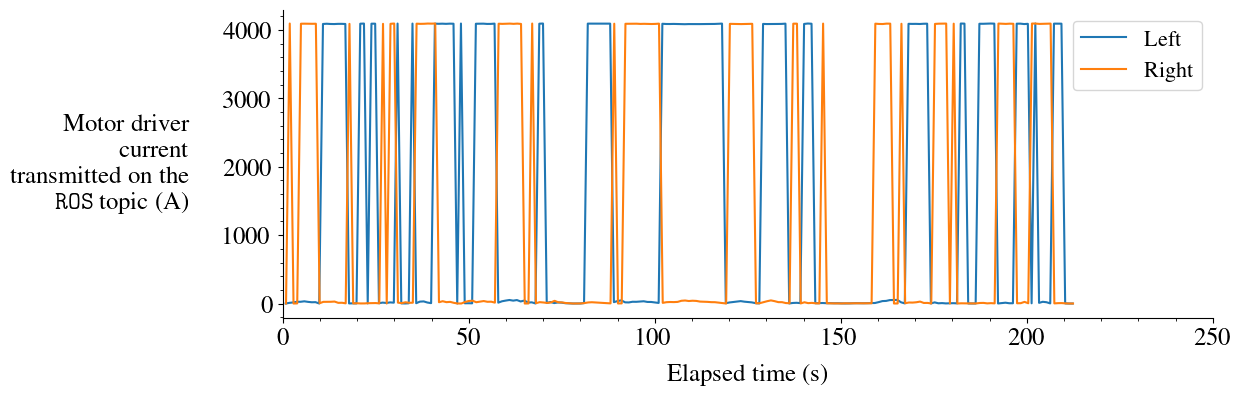

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(IL_df.time_rel, IL_df.IL, label="Left")
ax.plot(IR_df.time_rel, IR_df.IR, label="Right")

ax.spines[["right", "top"]].set_visible(False)
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.legend(fontsize=16)
ax.set_ylabel("Motor driver\ncurrent\ntransmitted on the\n\\texttt{ROS} topic (A)", rotation=0, ha="right", va="center")
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.set_xlabel("Elapsed time (s)")
ax.xaxis.set_label_coords(0.5, -0.15)

ax.set_xlim(left=0, right=250)

for ext in u.EXTS:
    fig.savefig(figdir/f"warthog-driver-currents.{ext}", bbox_inches="tight")



# Bytes

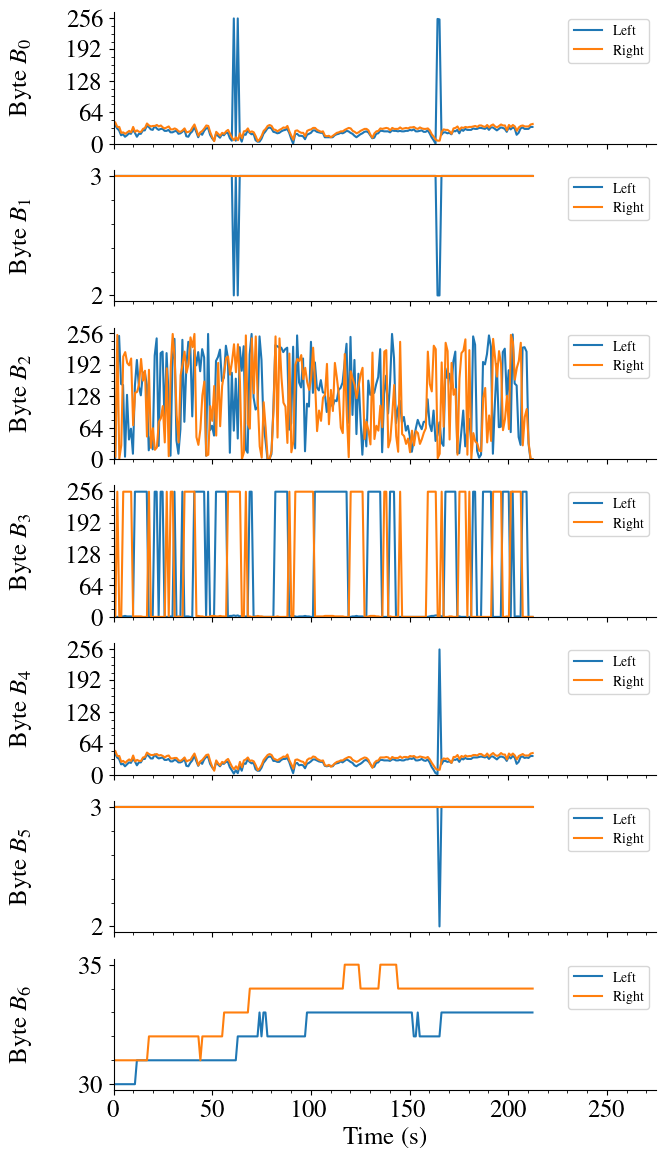

In [10]:
fig, axs = plt.subplots(nrows=7, sharex=True, figsize=(7, 14))
for idx, ax in enumerate(axs.reshape(-1)):
    ax.plot(canL_df.time_rel, canL_df[f"b{idx}"], label="Left")
    ax.plot(canR_df.time_rel, canR_df[f"b{idx}"], label="Right")
    ax.set_ylabel(f"Byte $B_{{{idx}}}$")
    ax.yaxis.set_label_coords(-0.15, 0.5)

    ax.legend(fontsize=10)

    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

axs[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(64))
axs[2].yaxis.set_major_locator(mpl.ticker.MultipleLocator(64))
axs[3].yaxis.set_major_locator(mpl.ticker.MultipleLocator(64))
axs[4].yaxis.set_major_locator(mpl.ticker.MultipleLocator(64))

ax.set_xlabel("Elapsed time (s)", fontsize=18)
ax.set_xlim(left=0, right=275)
axs[0].set_ylim(bottom=0)
axs[2].set_ylim(bottom=0)
axs[3].set_ylim(bottom=0)
axs[4].set_ylim(bottom=0)

for ext in u.EXTS:
    fig.savefig(figdir / f"warthog-bytes.{ext}", bbox_inches="tight")


# Current vs byte B3

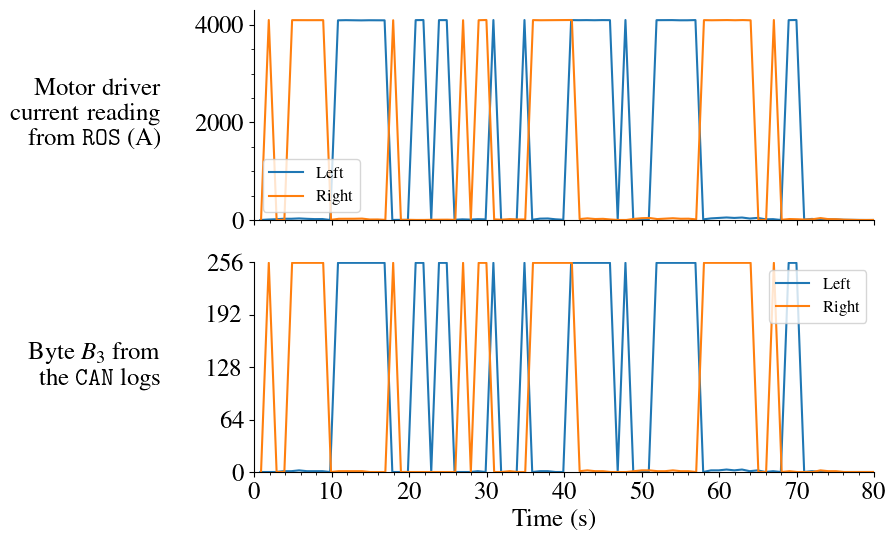

In [11]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

ax1.plot(IL_df.time_rel, IL_df.IL, label="Left")
ax1.plot(IR_df.time_rel, IR_df.IR, label="Right")
ax1.legend(fontsize=12)
ax1.set_ylabel("Motor driver\ncurrent reading\nfrom \\texttt{ROS} (A)", rotation=0, ha="right", va="center")
ax1.yaxis.set_label_coords(-0.15, 0.5)
ax1.spines[["right", "top"]].set_visible(False)
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.set_ylim(bottom=0)

ax2.plot(canL_df.time_rel, canL_df.b3, label="Left")
ax2.plot(canR_df.time_rel, canR_df.b3, label="Right")
ax2.legend(fontsize=12)
ax2.set_ylabel("Byte \\(B_3\\) from\nthe \\texttt{CAN} logs", rotation=0, ha="right", va="center")
ax2.yaxis.set_label_coords(-0.15, 0.5)
ax2.spines[["right", "top"]].set_visible(False)
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(64))
ax2.set_ylim(bottom=0, top=256)

ax2.set_xlim((0, 80))

ax2.set_xlabel("Elapsed time (s)", fontsize=18)

for ext in u.EXTS:
    fig.savefig(figdir / f"warthog-current-b3.{ext}", bbox_inches="tight")


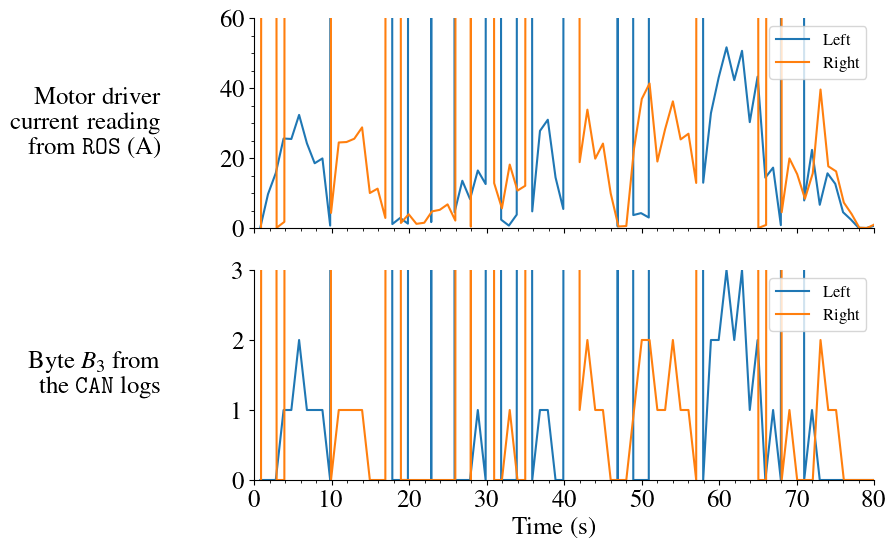

In [12]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

ax1.plot(IL_df.time_rel, IL_df.IL, label="Left")
ax1.plot(IR_df.time_rel, IR_df.IR, label="Right")
ax1.legend(fontsize=12)
ax1.set_ylabel("Motor driver\ncurrent reading\nfrom \\texttt{ROS} (A)", rotation=0, ha="right", va="center")
ax1.yaxis.set_label_coords(-0.15, 0.5)
ax1.spines[["right", "top"]].set_visible(False)
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.set_ylim(bottom=0, top=60)

ax2.plot(canL_df.time_rel, canL_df.b3, label="Left")
ax2.plot(canR_df.time_rel, canR_df.b3, label="Right")
ax2.legend(fontsize=12)
ax2.set_ylabel("Byte \\(B_3\\) from\nthe \\texttt{CAN} logs", rotation=0, ha="right", va="center")
ax2.yaxis.set_label_coords(-0.15, 0.5)
ax2.spines[["right", "top"]].set_visible(False)
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(64))
ax2.set_ylim(bottom=0, top=3)

ax2.set_xlim((0, 80))

fig.supxlabel("Time (s)", fontsize=18)

for ext in u.EXTS:
    fig.savefig(figdir / f"warthog-current-b3-fine.{ext}", bbox_inches="tight")


# CAN comparison with ROS topics

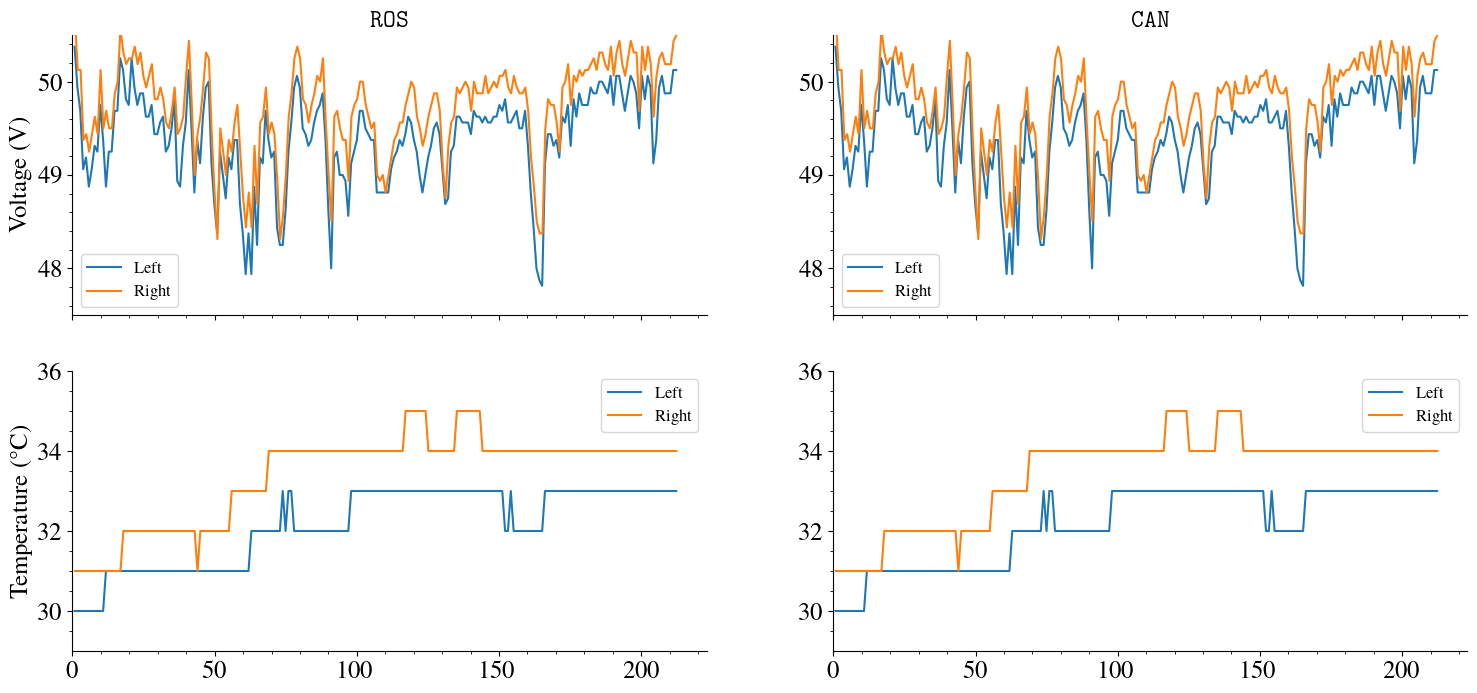

In [81]:
fig, subfigs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(18,8))
axs = subfigs.reshape(-1)

axs[0].plot(VL_df.time_rel, VL_df.VL, label="Left")
axs[0].plot(VR_df.time_rel, VR_df.VR, label="Right")
axs[2].plot(heatL_df.time_rel, heatL_df.hL, label="Left")
axs[2].plot(heatR_df.time_rel, heatR_df.hR, label="Right")

axs[1].plot(canL_df.time_rel, canL_df.CAN_V, label="Left")
axs[1].plot(canR_df.time_rel, canR_df.CAN_V, label="Right")
axs[3].plot(canL_df.time_rel, canL_df.b6, label="Left")
axs[3].plot(canR_df.time_rel, canR_df.b6, label="Right")

axs[0].set_title("\\texttt{ROS}")
axs[1].set_title("\\texttt{CAN}")

axs[0].set_ylabel("Voltage (V)")
axs[2].set_ylabel("Temperature (°C)")

axs[0].set_ylim(bottom=47.5, top=50.5)
axs[1].set_ylim(bottom=47.5, top=50.5)
axs[2].set_ylim(bottom=29, top=36)
axs[3].set_ylim(bottom=29, top=36)


for ax in axs:
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.set_xlim(left=0)
    ax.legend(fontsize=12)

for ext in u.EXTS:
    fig.savefig(figdir / f"warthog-canbus-bytes-VT-ros.{ext}", bbox_inches="tight")

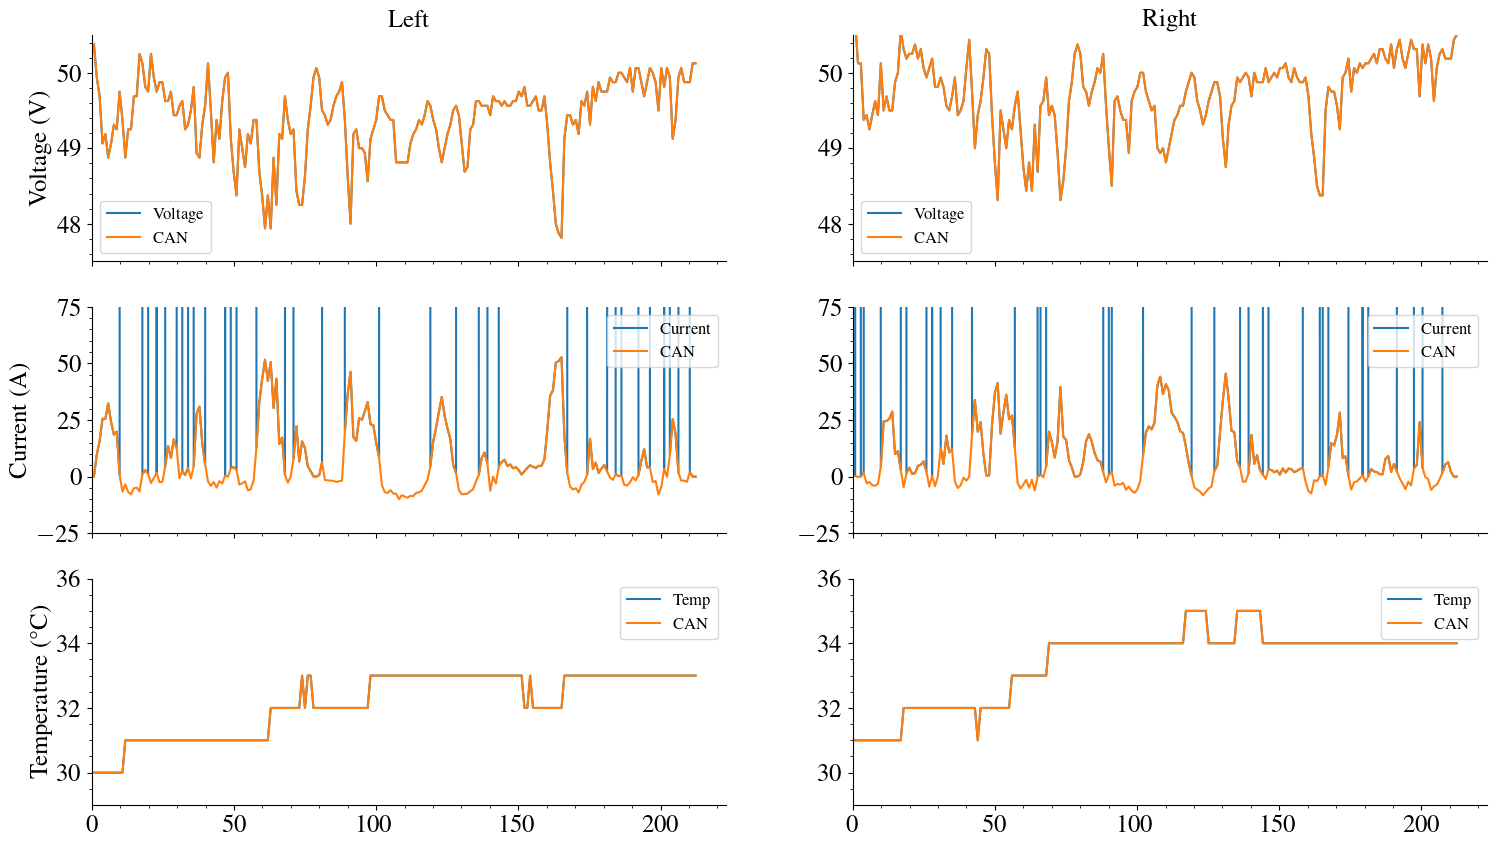

In [76]:
fig, subfigs = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(18,10))
axs = subfigs.reshape(-1)

axs[0].plot(VL_df.time_rel, VL_df.VL, label="Voltage")
axs[0].plot(canL_df.time_rel, canL_df.CAN_V, label="CAN")
axs[1].plot(VR_df.time_rel, VR_df.VR, label="Voltage")
axs[1].plot(canR_df.time_rel, canR_df.CAN_V, label="CAN")
axs[2].plot(IL_df.time_rel, IL_df.IL, label="Current")
axs[2].plot(canL_df.time_rel, canL_df.CAN_I, label="CAN")
axs[3].plot(IR_df.time_rel, IR_df.IR, label="Current")
axs[3].plot(canR_df.time_rel, canR_df.CAN_I, label="CAN")
axs[4].plot(heatL_df.time_rel, heatL_df.hL, label="Temp")
axs[4].plot(canL_df.time_rel, canL_df.b6, label="CAN")
axs[5].plot(heatR_df.time_rel, heatR_df.hR, label="Temp")
axs[5].plot(canR_df.time_rel, canR_df.b6, label="CAN")

axs[0].set_title("Left")
axs[1].set_title("Right")

axs[0].set_ylabel("Voltage (V)")
axs[2].set_ylabel("Current (A)")
axs[4].set_ylabel("Temperature (°C)")

axs[0].set_ylim(bottom=47.5, top=50.5)
axs[1].set_ylim(bottom=47.5, top=50.5)
axs[2].set_ylim(bottom=-25, top=75)
axs[3].set_ylim(bottom=-25, top=75)
axs[4].set_ylim(bottom=29, top=36)
axs[5].set_ylim(bottom=29, top=36)


for ax in axs:
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.set_xlim(left=0)
    ax.legend(fontsize=12)

for ext in u.EXTS:
    fig.savefig(figdir / f"warthog-canbus-bytes-ros.{ext}", bbox_inches="tight")

# Fixed current

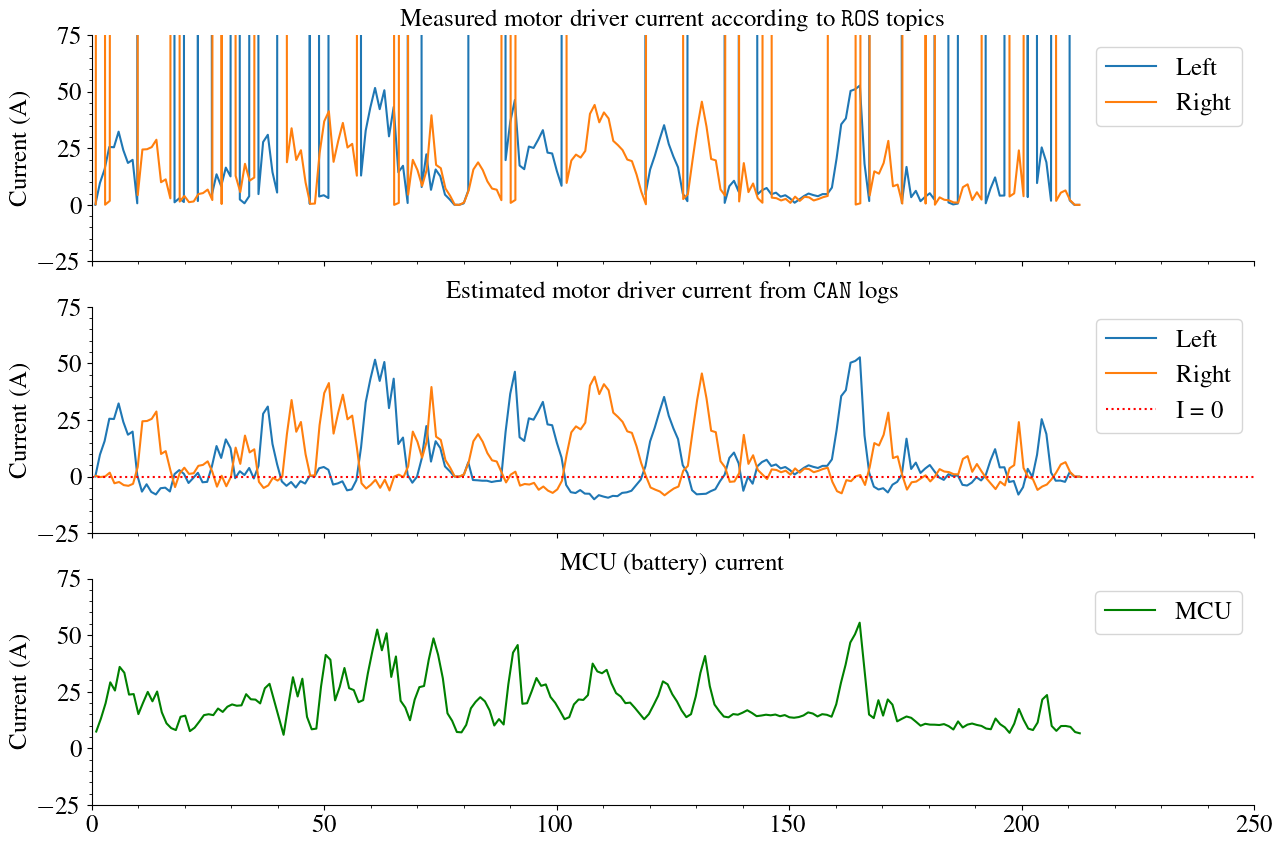

In [82]:
fig, [ax1,ax2,ax3] = plt.subplots(nrows=3, figsize=(15,10), sharex=True)

ax1.set_title("Measured motor driver current according to \\texttt{ROS} topics")
ax2.set_title("Estimated motor driver current from \\texttt{CAN} logs")
ax3.set_title("MCU (battery) current")

ax1.set_ylabel("Current (A)")
ax2.set_ylabel("Current (A)")
ax3.set_ylabel("Current (A)")
# ax1.yaxis.set_label_coords(-0.05, 0.5)
# ax2.yaxis.set_label_coords(-0.05, 0.5)
# ax3.yaxis.set_label_coords(-0.05, 0.5)

ax1.plot(IL_df.time_rel, IL_df.IL, label="Left")
ax1.plot(IR_df.time_rel, IR_df.IR, label="Right")
ax2.plot(canL_df.time_rel, canL_df.CAN_I, label="Left")
ax2.plot(canR_df.time_rel, canR_df.CAN_I, label="Right")
ax2.axhline(y=0, label="I = 0", linestyle=":", color="r")
ax3.plot(mcu_df.time_rel, mcu_df.iBatt, "g", label="MCU")

ax1.legend()
ax2.legend()
ax3.legend()

ax1.spines[["right", "top"]].set_visible(False)
ax2.spines[["right", "top"]].set_visible(False)
ax3.spines[["right", "top"]].set_visible(False)

ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax3.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

ax1.set_xlim(left=0, right=250)
ax1.set_ylim(bottom=-25, top=75)
ax2.set_ylim(bottom=-25, top=75)
ax3.set_ylim(bottom=-25, top=75)

for ext in u.EXTS:
    fig.savefig(figdir / f"warthog-current-ros-can-mcu.{ext}", bbox_inches="tight")


# rosbag correction

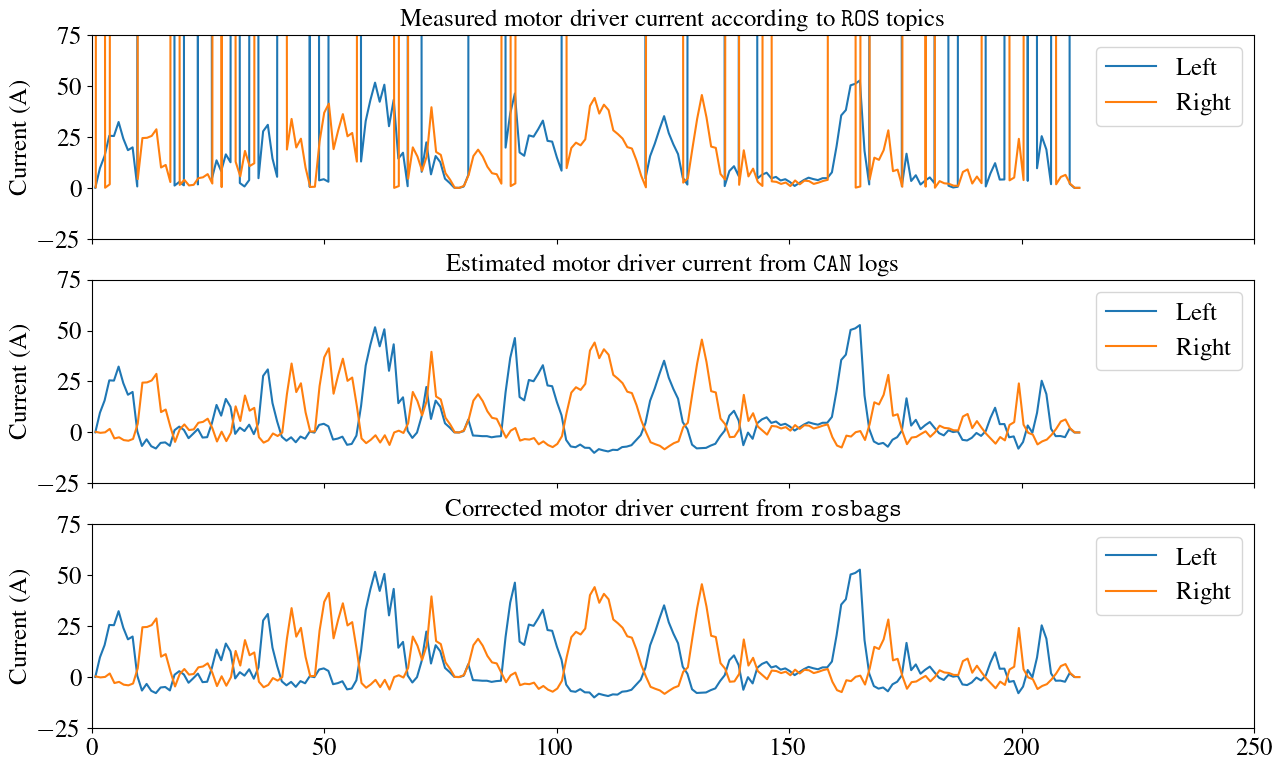

In [89]:
fig, [ax1,ax2,ax3] = plt.subplots(nrows=3, figsize=(15,9), sharex=True)

ax1.set_title("Measured motor driver current according to \\texttt{ROS} topics")
ax2.set_title("Estimated motor driver current from \\texttt{CAN} logs")
ax3.set_title("Corrected motor driver current from \\texttt{rosbags}")

ax1.set_ylabel("Current (A)")
ax2.set_ylabel("Current (A)")
ax3.set_ylabel("Current (A)")

IL_df["IL_ubytes"] = (16 * IL_df.IL).astype(int).apply(lambda x: struct.pack("<H", x))
IR_df["IR_ubytes"] = (16 * IR_df.IR).astype(int).apply(lambda x: struct.pack("<H", x))
IL_df["IL_hex"] = IL_df.IL_ubytes.apply(lambda x: struct.unpack("<h", x)[0])
IR_df["IR_hex"] = IR_df.IR_ubytes.apply(lambda x: struct.unpack("<h", x)[0])
IL_df["IL_corr"] = IL_df.IL_hex / 16
IR_df["IR_corr"] = IR_df.IR_hex / 16

# IL_df["IL_corr"] = ((16 * IL_df.IL).astype(int).apply(lambda x: struct.pack("<H", x)).apply(lambda x: struct.unpack("<h", x)[0]))/16


ax1.plot(IL_df.time_rel, IL_df.IL, label="Left")
ax1.plot(IR_df.time_rel, IR_df.IR, label="Right")
ax2.plot(canL_df.time_rel, canL_df.CAN_I, label="Left")
ax2.plot(canR_df.time_rel, canR_df.CAN_I, label="Right")
# ax2.axhline(y=0, label="I = 0", linestyle=":", color="r")
ax3.plot(IL_df.time_rel, IL_df.IL_corr, label="Left")
ax3.plot(IR_df.time_rel, IR_df.IR_corr, label="Right")

ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_xlim(left=0, right=250)
ax1.set_ylim(bottom=-25, top=75)
ax2.set_ylim(bottom=-25, top=75)
ax3.set_ylim(bottom=-25, top=75)

for ext in u.EXTS:
    fig.savefig(figdir / f"warthog-current-ros-can-rosbag.{ext}", bbox_inches="tight")

# Varia

(47.0, 53.0)

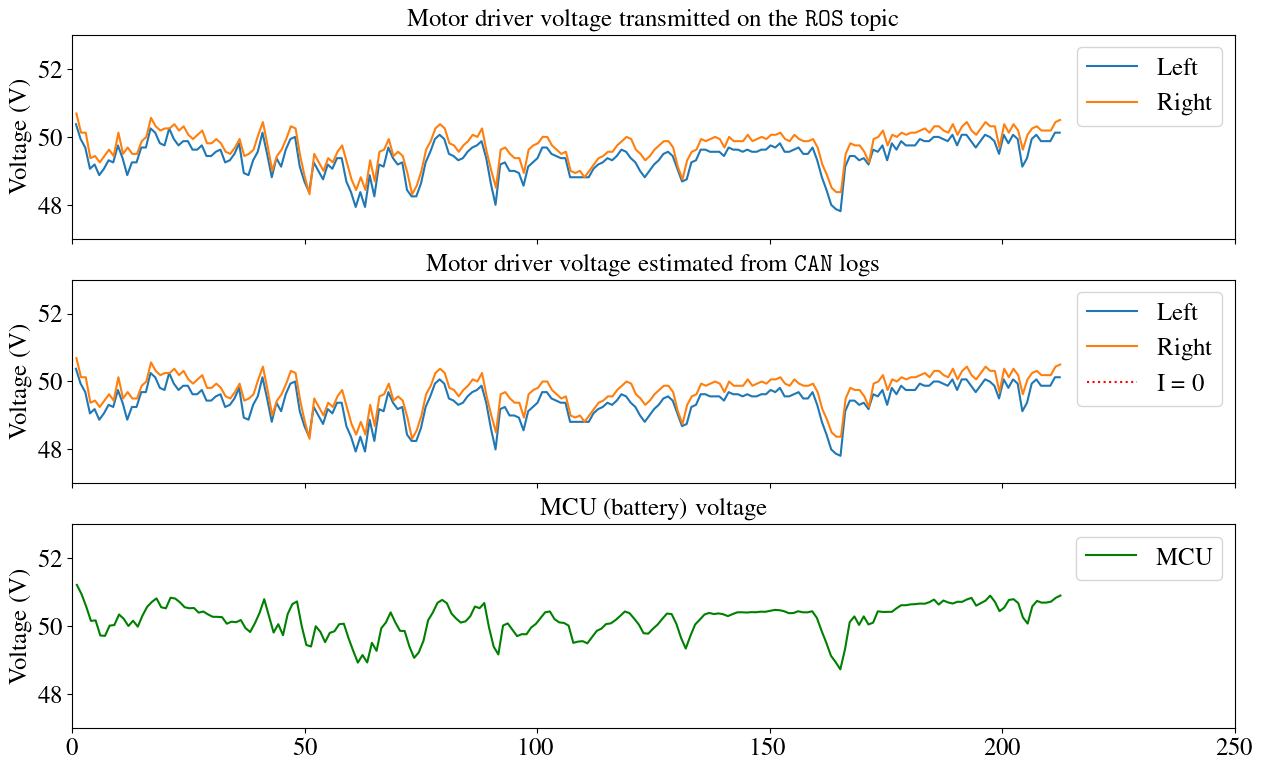

In [83]:
fig, [ax1,ax2,ax3] = plt.subplots(nrows=3, figsize=(15,9), sharex=True)

ax1.set_title("Motor driver voltage transmitted on the \\texttt{ROS} topic")
ax2.set_title("Motor driver voltage estimated from \\texttt{CAN} logs")
ax3.set_title("MCU (battery) voltage")

ax1.set_ylabel("Voltage (V)")
ax2.set_ylabel("Voltage (V)")
ax3.set_ylabel("Voltage (V)")
# ax1.yaxis.set_label_coords(-0.05, 0.5)
# ax2.yaxis.set_label_coords(-0.05, 0.5)
# ax3.yaxis.set_label_coords(-0.05, 0.5)

ax1.plot(VL_df.time_rel, VL_df.VL, label="Left")
ax1.plot(VR_df.time_rel, VR_df.VR, label="Right")
ax2.plot(canL_df.time_rel, canL_df.CAN_V, label="Left")
ax2.plot(canR_df.time_rel, canR_df.CAN_V, label="Right")
ax2.axhline(y=0, label="I = 0", linestyle=":", color="r")
ax3.plot(mcu_df.time_rel, mcu_df.vBatt, "g", label="MCU")

ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_xlim(left=0, right=250)
ax1.set_ylim(bottom=47, top=53)
ax2.set_ylim(bottom=47, top=53)
ax3.set_ylim(bottom=47, top=53)

In [ ]:
IL_value = IL_df.IL.iloc[0]
IR_value = IR_df.IR.iloc[0]

IL_ubytes = struct.pack("<H", int(16 * IL_value))
IR_ubytes = struct.pack("<H", int(16 * IR_value))
IL_hex = struct.unpack("<h", IL_ubytes)[0]
IR_hex = struct.unpack("<h", IR_ubytes)[0]

IL_hex, IR_hex

# IL_value = IL_df.IL.iloc[0]
# IR_value = IR_df.IR.iloc[0]


In [ ]:
faults = IL_df.IL[IL_df.IL > 4000]
correct = IL_df.IL_corr[faults.index]
faults.iloc[:5], correct.iloc[:5]

In [ ]:
fig, [ax1,ax2] = plt.subplots(nrows=2, figsize=(15,6), sharex=True)

ax1.set_title("Left")
ax2.set_title("Right")

ax1.set_ylabel("Current (A)")
ax2.set_ylabel("Current (A)")

ax1.plot(IL_df.time_rel, IL_df.IL, label="ROS")
ax2.plot(IR_df.time_rel, IR_df.IR, label="ROS")
ax1.plot(canL_df.time_rel, canL_df.uCAN_I, label="CAN")
ax2.plot(canR_df.time_rel, canR_df.uCAN_I, label="CAN")
ax1.axhline(y=0, label="I = 0", linestyle=":", color="r")
ax2.axhline(y=0, label="I = 0", linestyle=":", color="r")

ax1.legend()
ax2.legend()

ax1.set_xlim(left=0, right=250)
ax1.set_ylim(bottom=-25, top=100)
ax2.set_ylim(bottom=-25, top=100)

In [ ]:
canL_df.CAN_I.iloc[:5].to_numpy() / 16, canL_df.uCAN_I.iloc[:5].to_numpy() / 16

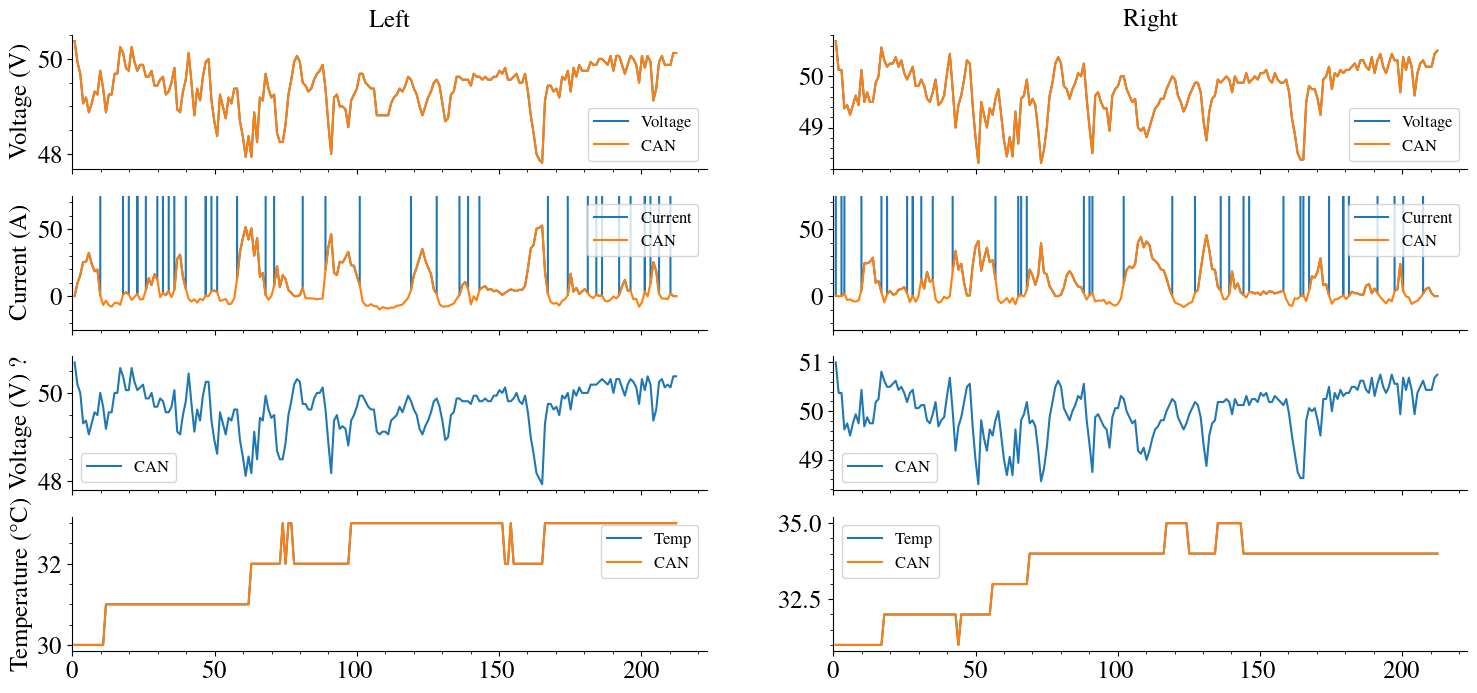

In [65]:
fig, subfigs = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(18,8))
axs = subfigs.reshape(-1)

axs[0].plot(VL_df.time_rel, VL_df.VL, label="Voltage")
axs[0].plot(canL_df.time_rel, canL_df.CAN_V, label="CAN")
axs[1].plot(VR_df.time_rel, VR_df.VR, label="Voltage")
axs[1].plot(canR_df.time_rel, canR_df.CAN_V, label="CAN")
axs[2].plot(IL_df.time_rel, IL_df.IL, label="Current")
axs[2].plot(canL_df.time_rel, canL_df.CAN_I, label="CAN")
axs[3].plot(IR_df.time_rel, IR_df.IR, label="Current")
axs[3].plot(canR_df.time_rel, canR_df.CAN_I, label="CAN")
# axs[4].plot(VL_df.time_rel, VL_df.VL, label="Voltage")
axs[4].plot(canL_df.time_rel, canL_df.uCAN_foo/16, label="CAN")
# axs[5].plot(VR_df.time_rel, VR_df.VR, label="Voltage")
axs[5].plot(canR_df.time_rel, canR_df.uCAN_foo/16, label="CAN")
axs[6].plot(heatL_df.time_rel, heatL_df.hL, label="Temp")
axs[6].plot(canL_df.time_rel, canL_df.b6, label="CAN")
axs[7].plot(heatR_df.time_rel, heatR_df.hR, label="Temp")
axs[7].plot(canR_df.time_rel, canR_df.b6, label="CAN")

axs[0].set_title("Left")
axs[1].set_title("Right")

axs[0].set_ylabel("Voltage (V)")
axs[2].set_ylabel("Current (A)")
axs[4].set_ylabel("Voltage (V) ?")
axs[6].set_ylabel("Temperature (°C)")

axs[2].set_ylim(bottom=-25, top=75)
axs[3].set_ylim(bottom=-25, top=75)


for ax in axs:
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.set_xlim(left=0)
    ax.legend(fontsize=12)


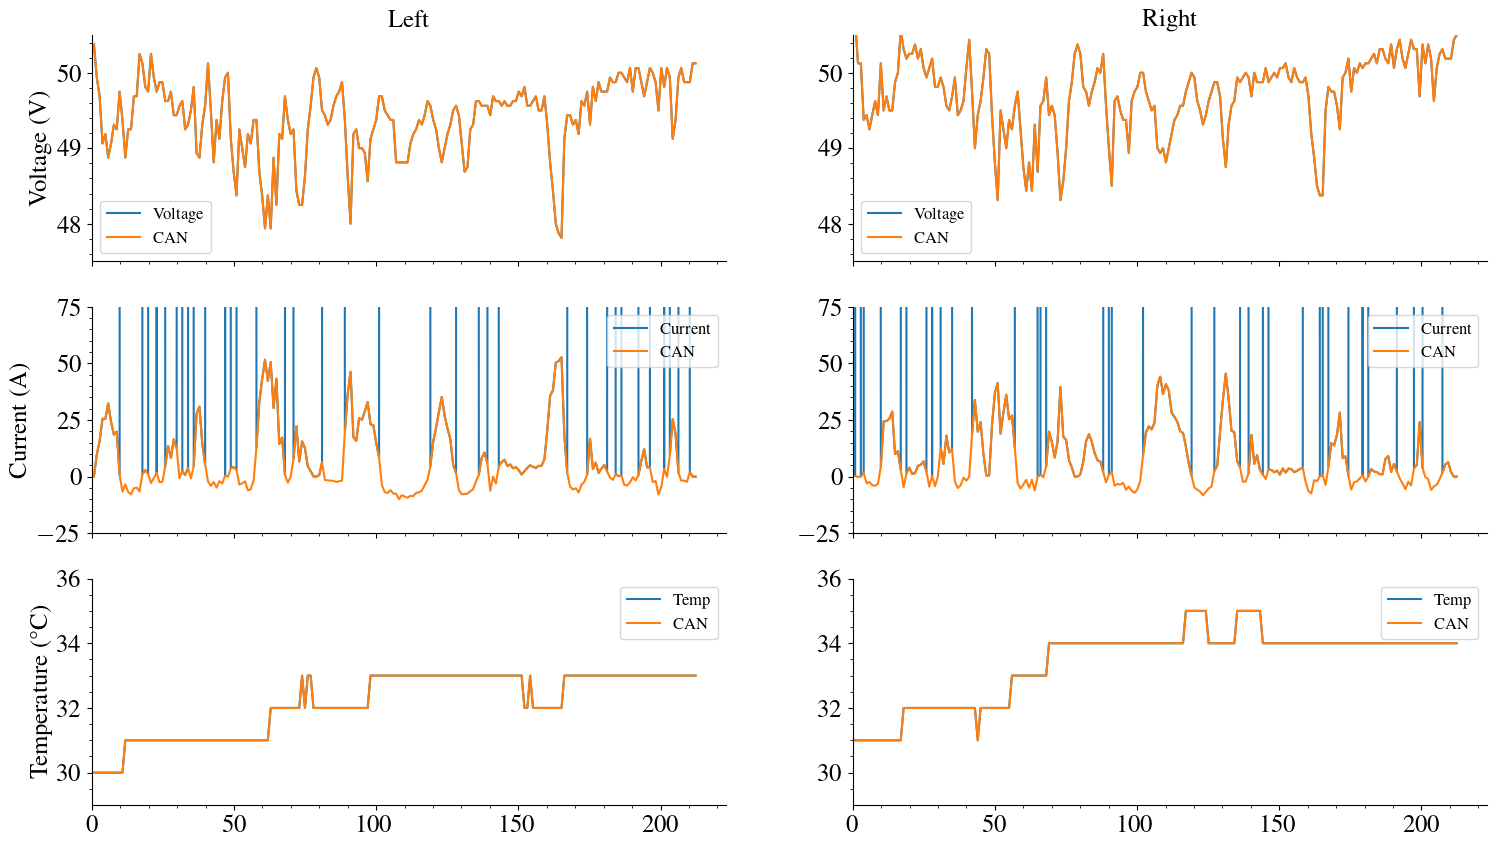

In [73]:
fig, subfigs = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(18,10))
axs = subfigs.reshape(-1)

axs[0].plot(VL_df.time_rel, VL_df.VL, label="Voltage")
axs[0].plot(canL_df.time_rel, canL_df.CAN_V, label="CAN")
axs[1].plot(VR_df.time_rel, VR_df.VR, label="Voltage")
axs[1].plot(canR_df.time_rel, canR_df.CAN_V, label="CAN")
axs[2].plot(IL_df.time_rel, IL_df.IL, label="Current")
axs[2].plot(canL_df.time_rel, canL_df.CAN_I, label="CAN")
axs[3].plot(IR_df.time_rel, IR_df.IR, label="Current")
axs[3].plot(canR_df.time_rel, canR_df.CAN_I, label="CAN")
axs[4].plot(heatL_df.time_rel, heatL_df.hL, label="Temp")
axs[4].plot(canL_df.time_rel, canL_df.b6, label="CAN")
axs[5].plot(heatR_df.time_rel, heatR_df.hR, label="Temp")
axs[5].plot(canR_df.time_rel, canR_df.b6, label="CAN")

axs[0].set_title("Left")
axs[1].set_title("Right")

axs[0].set_ylabel("Voltage (V)")
axs[2].set_ylabel("Current (A)")
axs[4].set_ylabel("Temperature (°C)")

axs[0].set_ylim(bottom=47.5, top=50.5)
axs[1].set_ylim(bottom=47.5, top=50.5)
axs[2].set_ylim(bottom=-25, top=75)
axs[3].set_ylim(bottom=-25, top=75)
axs[4].set_ylim(bottom=29, top=36)
axs[5].set_ylim(bottom=29, top=36)


for ax in axs:
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.set_xlim(left=0)
    ax.legend(fontsize=12)

In [ ]:
bstr = canL_df.bytes_str.iloc[0]
canL_df.bytes.iloc[0], bstr, struct.unpack("<3hb", bstr)

In [ ]:
print(struct.calcsize("<3hB"))
vals = struct.unpack("<3hB", bstr)
vals, vals[0] / 16, vals[1] / 16, vals[2] / 16
# canL_df.bytes_str.apply(struct.unpack, args=("<I",))
# canL_df.bytes_str.apply(list)


In [ ]:
fig, subfigs = plt.subplots(nrows=7, sharex=True, figsize=(6,14))
for idx, ax in enumerate(subfigs.reshape(-1)):
    ax.plot(canL_df.time_rel, canL_df[f"b{idx}"], label="Left")
    ax.plot(canR_df.time_rel, canR_df[f"b{idx}"], label="Right")
    ax.set_ylabel(f"Byte ${{{idx}}}$")
    ax.legend(fontsize=10)
    ax.yaxis.set_label_coords(-0.15, 0.5)

ax.set_xlim((0, reltime_max))

fig.supxlabel("Time (s)", fontsize=18)

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

ax1.plot(IL_df.time_rel, IL_df.IL, label="Left")
ax1.plot(IR_df.time_rel, IR_df.IR, label="Right")
ax1.legend(fontsize=12)
ax1.set_ylabel("Motor driver\ncurrent\ntransmitted on the\n\\texttt{ROS} topic (A)", rotation=0, ha="right", va="center")
ax1.yaxis.set_label_coords(-0.15, 0.5)
ax1.spines[["right", "top"]].set_visible(False)
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax1.set_ylim(bottom=0)
ax1.set_ylim(bottom=0, top=60)

ax2.plot(canL_df.time_rel, canL_df.b3, label="Left")
ax2.plot(canR_df.time_rel, canR_df.b3, label="Right")
# ax2.plot(canL_df.time_rel, canL_df.b2, label="Left b2")
# ax2.plot(canR_df.time_rel, canR_df.b2, label="Right b2")
ax2.legend(fontsize=12)
ax2.set_ylabel("Transmitted\nbyte through\nthe \\texttt{CAN} bus", rotation=0, ha="right", va="center")
ax2.yaxis.set_label_coords(-0.15, 0.5)
ax2.spines[["right", "top"]].set_visible(False)
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(64))
ax2.set_ylim(bottom=0, top=4)

ax2.set_xlim((0, 80))

fig.supxlabel("Time (s)", fontsize=18)

In [ ]:
can_df = u.read_canlog(can_path)
frameIDs = can_df.frameID.unique()
can_dfs = {fID: can_df[can_df.frameID == fID].copy() for fID in frameIDs}

for fID in frameIDs:
    frame_df = can_dfs[fID]
    frame_df["packet"] = frame_df.can_packet.str[4:]
    packet_len = frame_df.packet.str.len().unique()[0]
    u.decompose_packet(frame_df, "packet", n_bytes=packet_len//2)
    frame_df["time_rel"] = frame_df.time - time_min
    frame_mask = (frame_df.time_rel > 0) & (frame_df.time < time_max)
    frame_df = frame_df[frame_mask].copy()
    can_dfs[fID] = {"csv": frame_df, "len":packet_len//2}


In [ ]:
print([f for f in sorted(can_dfs.keys())])


In [ ]:
canv.plot_bytes("501", can_dfs=can_dfs, reltime_max=reltime_max);

In [ ]:
canv.plot_bytes("481", can_dfs=can_dfs, reltime_max=reltime_max);

In [ ]:
canL_df.head()

In [ ]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, sharex=True, figsize=(15, 9))

packet_len = len(canL_df.columns) - 16
byte_columns = [f"b{i}" for i in range(packet_len)]
byte_arrL = canL_df[byte_columns].copy().to_numpy()
byte_arrR = canR_df[byte_columns].copy().to_numpy()
# coeffs = np.array([0, 1/256, 1/16, 16, 0, 0, 0])
# coeffs = np.array([1/4096, 1/256, 1/16, 16, 0, 0, 0])
coeffs = np.array([0, 1/4096, 1/16, 16, 0, 0, 0])
canL_value = byte_arrL @ coeffs
canR_value = byte_arrR @ coeffs

ax1.plot(IL_df.time_rel, IL_df.IL, label="Current")
ax2.plot(IR_df.time_rel, IR_df.IR, label="Current")
ax1.plot(canL_df.time_rel, canL_value, label="CAN")
ax2.plot(canR_df.time_rel, canR_value, label="CAN")
ax3.plot(canR_df.time_rel, canR_value - 127*16, label="Rectified")

ax1.legend(fontsize=12)
ax2.legend(fontsize=12)
ax1.set_ylabel("Left")
ax2.set_ylabel("Right")
ax3.set_ylabel("Byte")
ax1.spines[["right", "top"]].set_visible(False)
ax2.spines[["right", "top"]].set_visible(False)
ax3.spines[["right", "top"]].set_visible(False)
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax3.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax3.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.set_ylim(bottom=0, top=100)
ax2.set_ylim(bottom=0, top=100)

ax2.set_xlim(left=0)

fig.supxlabel("Time (s)", fontsize=18)
